![](img/banner_protein.jpg)

## Overview
The goal of this competition is classification of mixed protein patterns. However, unlike most image labeling tasks, where binary or multiclass labling is considered, in this competition each image can have multiple labels. Multiclass multilabel task has its own specific affecting the design of the model and the loss function. Moreover, the slassified images are quite different from imageNet; therefore, despite of using a pretrained model is quite helpful, a substantial retraining of entire model is needed. An additional challenge is 4-channel input to the model (RGBY), which is different from ones used in most of pretrained models (RGB input).

In this notebook I will show how to handle the above challenges and get started with this competition. I will begin with using a light ResNet34 model and low-resolution images to have a baseline that can be used later to select highter end models and explore the effect of image resolution on the prediction accuracy. **The validation F1 score of the model is ~0.65-0.7**, and I was able to get `0.460` public LB score. Though resultsare slightly different from one run to another because F1 macro metric is unstable, and several items of rear classes contribute in the same way as thousands items of common classes, 1/28.

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastaidev import *
from fastaidev.vision import *

In [3]:
#export
import cv2
import torch
import torch.nn as nn
import torchvision

In [4]:
plt.style.use(['dark_background'])
np.random.seed(66)

## Paths

In [5]:
PROJ_PATH = Path.cwd()
DATA_PATH = Path.home()/".fastai/data/competitions"
PATH = DATA_PATH/"human-protein-atlas-image-classification"

## EDA

In [6]:
df = pd.read_csv(PATH/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [7]:
df.shape

(31072, 2)

In [8]:
id2label = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [9]:
label2id = {v:k for k,v in id2label.items()}

In [12]:
labelize = lambda row: ",".join([id2label[int(o)] for o in row.Target.split(" ")])
# Unit test
#labelize(df.iloc[0])

In [13]:
df['Target_lable'] = df.apply(labelize, axis=1)

In [14]:
df.to_feather(PATH/'protein')

In [15]:
#df.to_feather(PATH/'protein')
import feather
df = feather.read_dataframe(PATH/'protein')

## Data

In [16]:
#export
def open_rgby(fn:PathOrStr, cls:type=Image)->Image:
    'https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb'
    fn = str(fn)
    if fn.endswith('.png'): fn = fn[:-4]
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    x = [cv2.imread(fn+f'_{color}.png', flags).astype(np.float32)/255 
                    for color in colors]
    x = np.stack(x, axis=-1)
    x = pil2tensor(x,np.float32)
    return cls(x)

In [17]:
src = (ImageItemList.from_csv(PATH, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [18]:
src.train.x.open = open_rgby
src.valid.x.open = open_rgby

In [19]:
test_fns = [str(fn).split('_')[0]+'.png' for fn in (PATH/'test').glob('*_blue.png')]

In [20]:
src.add_test(test_fns, label='0');

In [21]:
src.test.x.open = open_rgby

In [22]:
sz,bs = 256,64

In [23]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30.,
                      max_zoom=1, max_lighting=0.05, max_warp=0.)

## Calculate norm stats 

In [24]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [25]:
data = (src.transform(tfms=tfms, tfm_y=False, size=sz)
           .databunch(bs=bs)
           .normalize(protein_stats))

## Sanity check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


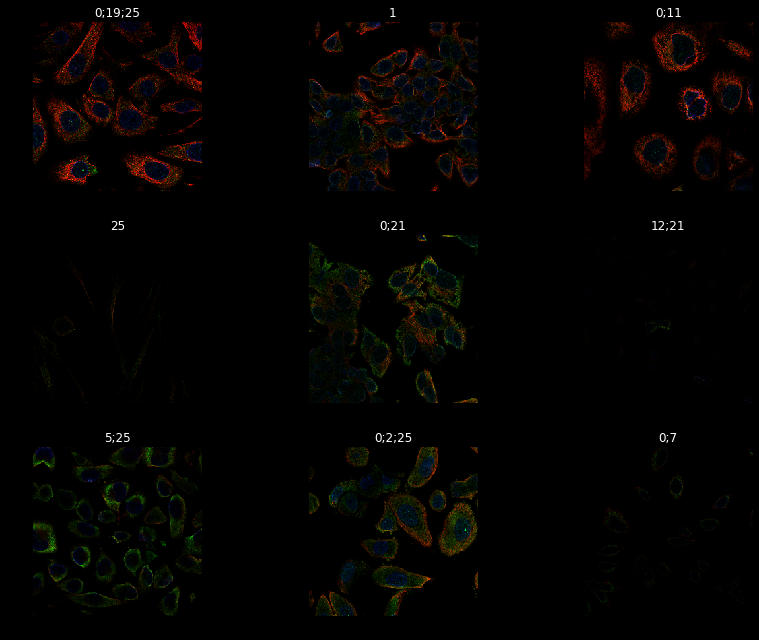

In [26]:
data.show_batch(rows=3, figsize=(12,9))

## Training

One of the challenges in this competition is 4-channel input (RGBY) that limits usage of ImageNet pretrained models taking RGB input. However, the input dataset is too tiny to train even a low capacity model like ResNet34 from scratch. I propose to use the following way to work around this limitation. The most common way to convert RGBY to RGB is just dropping Y channel while keeping RGB without modification. Therefore I replace the first convolution layer from 7x7 3->64 to 7x7 4->64 while keeping weights from 3->64 and setting new initial weighs from Y channel to be zero. It allows using the original weights to initialize the network while giving the opportunity to the model to incorporate Y channel into prediction during the following training (when the first layers of the model are unfreezed). In the following hiden cell I put a code from fast.ai library with adding several lines for the replacement of the first convolutional layer.

Since a multiclass multilabel task is considered, there are several things about the model that should be pointed out. First, the SOFTMAX MUST NOT BE USED as an output layer because it encourages a single label prediction. The common output function for multilabel tasks is SIGMOID. However, combining the sigmoid with the loss function (like in BCE with logits loss or in Focal loss used in this notebook) allows log(sigmoid) optimization of the numerical stability of the loss function. Therefore, sigmoid is also removed.

```python
md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]
```
- [ ] [Gradient Clipping](https://docs.fast.ai/train.html#GradientClipping)
- [ ] Focal loss

In [28]:
#export
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [29]:
#export
class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()

        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        # we initialize this conv to take in 4 channels instead of 3
        # we keeping corresponding weights and initializing new weights with zeros
        # this trick taken from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [30]:
def resnet50(pretrained): return Resnet4Channel(encoder_depth=50)
x_resnet50 = Resnet4Channel(encoder_depth=50)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/achen/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:15<00:00, 6714193.19it/s]


In [ ]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [ ]:
learn = create_cnn(data, arch=x_resnet50, loss_func=F.binary_cross_entropy_with_logits,
        path=PATH, metrics=[f1_score], callback_fns=partial(GradientClipping, clip=0.1))

As usual, I begin with finding the optimal learning rate. The following function runs training with different lr and records the loss. Increase of the loss indicates onset of divergence of training. The optimal lr lies in the vicinity of the minimum of the curve but before the onset of divergence. Based on the following plot, for the current setup the divergence starts at ~1e-1, and the recommended learning rate is ~2e-2.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

First, I train only the head of the model while keeping the rest frozen. It allows to avoid corruption of the pretrained weights at the initial stage of training due to random initialization fo the head layers. So the power of transfer learning is fully utilized when the training is continued.

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(1, slice(lr))

In [ ]:
learn.save('stage-1-rn50-datablocks')

Next, I unfreeze all weights and allow training of entire model. One trick that I use is differential learning rate: the lr of the head part is still lr, while the middle layers of the model are trained with lr/3, and the base part is trained with even smaller lr/10. Despite the low-level detectors do note vary much from one image data set to another, the yellow channel should be trained, and also the images are quite different from ImageNet; therefore, I decrease the learning rate for first alyers only by 10 times. If there was no necessity to train an additional channel and the images were more similar to ImageNet, the learning rates could be [lr/100, lr/10, lr]. Another trich is learning rate annealing. Periodic lr increase followed byslow decrease drives the system out of steep minima (when lr is high) towards broader ones (which are explored when lr decreases) that enhances the ability of the model to generalize and reduces overfitting. The length of the cycles gradually increases during training.

In [ ]:
learn.load('stage-1-rn50-datablocks');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
learn.fit_one_cycle(15, slice(2e-6, lr/5))

In [ ]:
learn.save('stage-2-rn50')

In [ ]:
preds,_ = learn.get_preds(DatasetType.Test)

In [ ]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)

In [ ]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/protein_predictions_datablocks.csv -m "Submit for sanity check"